In [1]:
import numpy as np
import scipy as sc 
from numba import jit
from numpy.random import binomial
from scipy.stats import beta
import matplotlib.pyplot as plt

In [2]:
def sample(n, alpha):
    x0 = 0.5
    samples = [x0]
    for _ in range(n):
        if binomial(1,samples[-1]):
            samples.append(beta.rvs(alpha+1, 1, size=1)[0])
        else:
            samples.append(samples[-1])
    return samples


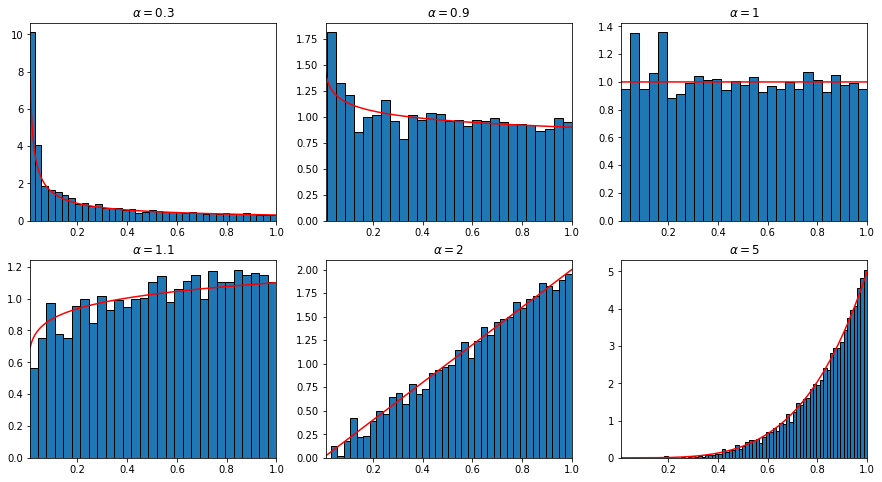

In [56]:
f, axarr = plt.subplots(2, 3, figsize = (15,8))
alphas = [0.3,0.9,1,1.1,2,5]
for (ax, alpha) in zip(axarr.flatten(), alphas): 
    x = np.linspace(0.01, 1, 2000)
    pdf = alpha*x**(alpha-1)
    ax.plot(x, pdf, 'r')
    ax.hist(sample(40000, alpha)[20000:], bins='auto', color='C0', density=True, ec='black', )
    ax.set_xlim(0.01,1)
    ax.set_title(r'$\alpha = $'+str(alpha))
plt.savefig('plot.eps', bbox_inches='tight')
plt.show()

In [32]:
def sample_metropolis(n, alpha):
    x0 = 0.5
    samples = [x0]
    for _ in range(n):
        y = beta.rvs(alpha+1, 1, size=1)[0]
        x = samples[-1]
        prob = min(1, y**(alpha-1) * x**(alpha)/(x**(alpha-1) * y**(alpha)))
        if binomial(1,prob):
            samples.append(y)
        else:
            samples.append(samples[-1])
    return samples


def sample_metropolis_numpy(n, alpha):
    x0 = 0.5
    samples = np.full((n+1,), x0)
    ys = np.full((n+1,), x0)
    x = x0
    for i in range(1, n+1):
        y = beta.rvs(alpha+1, 1, size=1)[0]
        ys[i] = y
        prob = min(1, y**(alpha-1) * x**(alpha)/(x**(alpha-1) * y**(alpha)))
        if binomial(1,prob):
            samples[i] = y
            x = y
        else:
            samples[i] = x
    return (ys, samples)

In [33]:
alpha = 5
%timeit sample_metropolis(40000, alpha)

3.37 s ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit sample_metropolis_numpy(40000, alpha)

3.39 s ± 144 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


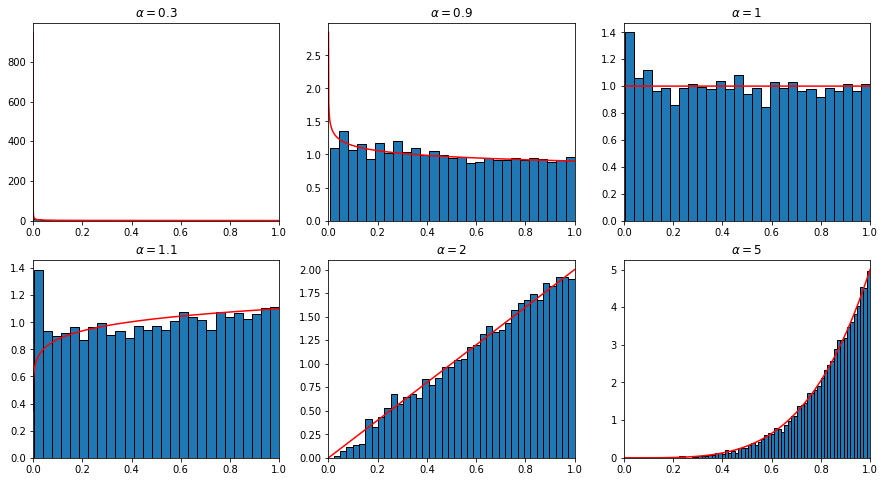

In [24]:
f, axarr = plt.subplots(2, 3, figsize = (15,8))
alphas = [0.3,0.9,1,1.1,2,5]
for (ax, alpha) in zip(axarr.flatten(), alphas): 
    x = np.linspace(0.00001, 1, 2000)
    pdf = alpha*x**(alpha-1)
    ax.plot(x, pdf, 'r')
    ax.hist(sample_metropolis(40000, alpha)[20000:], bins='auto', color='C0', density=True, ec='black', )
    ax.set_xlim(0.00001,1)
    ax.set_title(r'$\alpha = $'+str(alpha))
plt.savefig('plot.eps', bbox_inches='tight')
plt.show()

In [23]:
alpha = 5
print(alpha/(1+alpha))
print(np.mean(sample(10000, 5)[1000:]))
print(np.mean(sample_metropolis(10000, 5)[1000:]))
print(np.mean(sample_metropolis_numpy(10000, 5)[1]))

0.8333333333333334
0.8332623056602599
0.8306441329527574
0.8315632505537844


In [39]:
def comp_metropolis_acc(ys, alpha): 
    n = len(ys)-1
    zeta = np.zeros((n+1,n+1))
    tau = np.zeros(n+1)
    phi = np.zeros(n+1)
    
    w = alpha/(1+alpha)*1/ys
    rho = np.minimum(np.outer(1/w,w), 1)
    np.fill_diagonal(zeta, 1)
    temp = 1-rho
    for i in range(n):
        zeta[i, i+1:] = np.cumprod(temp[i, i+1:])
    tau[0] = 1
    phi[0] = np.sum(zeta[0, 0:])
    for i in range(1,n+1):
        tau[i] = np.sum(tau[:i]*zeta[:i, i-1]*rho[:i, i])
        phi[i] = tau[i]*np.sum(zeta[i, i:])
    return np.mean(phi*ys)


@jit(nopython=True)
def comp_metropolis_acc_numba(ys, alpha): 
    n = len(ys)-1
    zeta = np.zeros((n+1,n+1))
    tau = np.zeros(n+1)
    phi = np.zeros(n+1)
    
    w = alpha/(1+alpha)*1/ys
    rho = np.minimum(np.outer(1/w,w), 1)
    np.fill_diagonal(zeta, 1)
    temp = 1-rho
    for i in range(n):
        zeta[i, i+1:] = np.cumprod(temp[i, i+1:])
    tau[0] = 1
    phi[0] = np.sum(zeta[0, 0:])
    for i in range(1,n+1):
        tau[i] = np.sum(tau[:i]*zeta[:i, i-1]*rho[:i, i])
        phi[i] = tau[i]*np.sum(zeta[i, i:])
    return np.mean(phi*ys)

In [41]:
alpha = 5
ys, _ = sample_metropolis_numpy(20000, alpha)

In [42]:
%timeit comp_metropolis_acc(ys, alpha)

KeyboardInterrupt: 

In [ ]:
%timeit comp_metropolis_acc_numba(ys, alpha)

In [119]:
n = 100
alpha = 5
x0 = 0.5
samples = np.full((n+1,), x0)
ys = np.full((n+1,), x0)
x = x0
for i in range(1, n+1):
    y = beta.rvs(alpha+1, 1, size=1)[0]
    ys[i] = y
    prob = min(1, y**(alpha-1) * x**(alpha)/(x**(alpha-1) * y**(alpha)))
    if binomial(1,prob):
        samples[i] = y
        x = y
    else:
        samples[i] = x

w = np.zeros(n+1)
rho = np.zeros((n,n+1))
zeta = np.zeros((n+1,n+1))
tau = np.zeros(n+1)
phi = np.zeros(n+1)

w = alpha/(1+alpha)*1/ys
rho = np.minimum(np.outer(1/w,w), 1)
np.fill_diagonal(zeta, 1)
temp = 1-rho
for i in range(n):
    zeta[i, i+1:] = np.cumprod(temp[i, i+1:])
tau[0] = 1
phi[0] = np.sum(zeta[0, 0:])
for i in range(1,n+1):
    tau[i] = np.sum(tau[:i]*zeta[:i, i-1]*rho[:i, i])
    phi[i] = tau[i]*np.sum(zeta[i, i:])

In [116]:
i=n-1
np.sum(zeta[i, i:])

1.0

In [118]:
zeta.shape

(100, 101)

In [21]:
sample_metropolis_numpy(10000, 5)[1]

array([0.5       , 0.5       , 0.74518123, ..., 0.8246997 , 0.86421822,
       0.86421822])